In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 46.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# all libraries
import torch
from torch_geometric.loader import LinkNeighborLoader
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch import Tensor
import tqdm

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch_geometric.transforms as T

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import string
import re

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 8),
          'figure.dpi': 100,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

import os

In [ ]:
# movies_df1 = pd.read_csv("/content/drive/MyDrive/ml-latest-small/movies.csv",index_col='movieId')
# movies_df1.shape

In [ ]:
movies_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/movies.csv",names=['movieId', 'title', 'genres'])
ratings_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ratings.csv")

In [ ]:
movies_df.shape

(9743, 3)

In [ ]:
movies_df.head()

,movieId,title,genres
0,movieId,title,genres
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance


In [ ]:
movies_df['movieId']

0       movieId
1             1
2             2
3             3
4             4
         ...   
9738     193581
9739     193583
9740     193585
9741     193587
9742     193609
Name: movieId, Length: 9743, dtype: object

In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_df.shape

(100836, 4)

In [ ]:
ratings_df.userId.nunique()

610

In [ ]:
ratings_df.movieId.nunique()

9724

In [ ]:
ratings_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

<ipython-input-16-753d9b8e54c6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df,palette=custom_palette)
<ipython-input-16-753d9b8e54c6>:2: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='rating', data=ratings_df,palette=custom_palette)


<Axes: xlabel='rating', ylabel='count'>

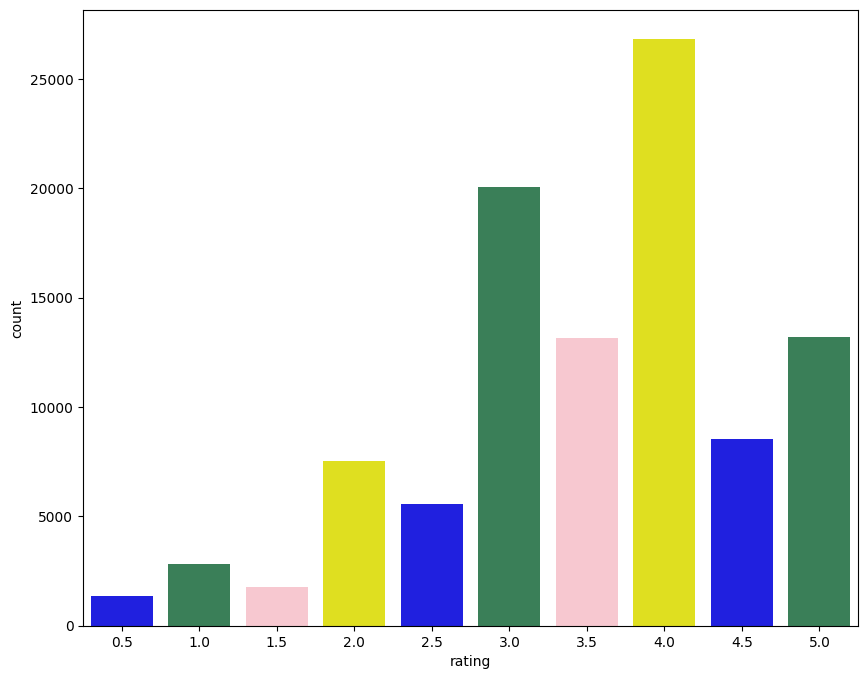

In [ ]:
custom_palette = ["blue", "seagreen", "pink", "yellow"]
sns.countplot(x='rating', data=ratings_df,palette=custom_palette)

In [ ]:
movies_df=movies_df.iloc[1:,:]
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror","Comedy","Romance"]].head())
movie_features = torch.from_numpy(genres.values).to(torch.float)
print(movie_features.size())

   Action  Adventure  Drama  Horror  Comedy  Romance
1       0          1      0       0       1        0
2       0          1      0       0       0        0
3       0          0      0       0       1        1
4       0          0      1       0       1        1
5       0          0      0       0       1        0
torch.Size([9742, 20])


In [ ]:
movie_features[1:4]

tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]])

In [ ]:
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print(unique_user_id.head())
print()

unique_movie_id = ratings_df['movieId'].unique()
# print(unique_movie_id)
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print(unique_movie_id.head())


ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')

print("ratings_user_id:")
print(ratings_user_id.head())

ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)
print()
print("Final edge indices pointing from users to movies:")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        3         1
2        6         2
3       47         3
4       50         4
ratings_user_id:
   userId  mappedID
0       1         0
1       1         0
2       1         0
3       1         0
4       1         0

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    1,    2,  ..., 3121, 1392, 2873]])


In [ ]:
data = HeteroData()

data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

data["movie"].x = movie_features
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie
data = T.ToUndirected()(data)

In [ ]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)
# print(data["user", "rates", "movie"].edge_index)
train_data, val_data, test_data = transform(data)

In [ ]:
train_data["user", "rates", "movie"].edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

edge_label_index = train_data["user", "rates", "movie"].edge_label_index
# print(edge_label_index)
edge_label = train_data["user", "rates", "movie"].edge_label
# print(edge_label)
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

from torch import Tensor
#sageconv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)

        if "edge_label_index" in data["user", "rates", "movie"]:
            edge_label_index = data["user", "rates", "movie"].edge_label_index
        else:
            edge_label_index = data["user", "rates", "movie"].edge_index

        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            edge_label_index,
        )

        return pred

model = Model(hidden_channels=64)

In [ ]:
sageconvloss=[]

In [ ]:
import tqdm
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
print("Training model with sageconv")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs=70
for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}",sep='')
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Loss: {total_loss / total_examples:.4f}")
    loss = total_loss / total_examples
    sageconvloss.append(round(loss, 4))


Device: 'cuda'
Training model with sageconv
Epoch: 1


100%|██████████| 190/190 [00:21<00:00,  8.76it/s]


Loss: 0.4403
Epoch: 2


100%|██████████| 190/190 [00:07<00:00, 25.85it/s]


Loss: 0.3504
Epoch: 3


100%|██████████| 190/190 [00:08<00:00, 21.63it/s]


Loss: 0.3262
Epoch: 4


100%|██████████| 190/190 [00:08<00:00, 23.15it/s]


Loss: 0.3151
Epoch: 5


100%|██████████| 190/190 [00:08<00:00, 23.58it/s]


Loss: 0.2991
Epoch: 6


100%|██████████| 190/190 [00:10<00:00, 18.54it/s]


Loss: 0.2892
Epoch: 7


100%|██████████| 190/190 [00:08<00:00, 21.39it/s]


Loss: 0.2771
Epoch: 8


100%|██████████| 190/190 [00:08<00:00, 22.48it/s]


Loss: 0.2682
Epoch: 9


100%|██████████| 190/190 [00:08<00:00, 21.58it/s]


Loss: 0.2604
Epoch: 10


100%|██████████| 190/190 [00:07<00:00, 26.23it/s]


Loss: 0.2521
Epoch: 11


100%|██████████| 190/190 [00:08<00:00, 21.89it/s]


Loss: 0.2434
Epoch: 12


100%|██████████| 190/190 [00:08<00:00, 21.52it/s]


Loss: 0.2442
Epoch: 13


100%|██████████| 190/190 [00:07<00:00, 25.74it/s]


Loss: 0.2401
Epoch: 14


100%|██████████| 190/190 [00:09<00:00, 19.72it/s]


Loss: 0.2335
Epoch: 15


100%|██████████| 190/190 [00:08<00:00, 23.05it/s]


Loss: 0.2294
Epoch: 16


100%|██████████| 190/190 [00:08<00:00, 23.70it/s]


Loss: 0.2211
Epoch: 17


100%|██████████| 190/190 [00:08<00:00, 21.62it/s]


Loss: 0.2214
Epoch: 18


100%|██████████| 190/190 [00:07<00:00, 25.85it/s]


Loss: 0.2095
Epoch: 19


100%|██████████| 190/190 [00:08<00:00, 21.46it/s]


Loss: 0.2118
Epoch: 20


100%|██████████| 190/190 [00:08<00:00, 21.41it/s]


Loss: 0.2073
Epoch: 21


100%|██████████| 190/190 [00:07<00:00, 25.97it/s]


Loss: 0.2054
Epoch: 22


100%|██████████| 190/190 [00:08<00:00, 21.53it/s]


Loss: 0.2005
Epoch: 23


100%|██████████| 190/190 [00:07<00:00, 24.59it/s]


Loss: 0.1944
Epoch: 24


100%|██████████| 190/190 [00:08<00:00, 22.58it/s]


Loss: 0.1925
Epoch: 25


100%|██████████| 190/190 [00:08<00:00, 21.54it/s]


Loss: 0.1903
Epoch: 26


100%|██████████| 190/190 [00:07<00:00, 25.66it/s]


Loss: 0.1841
Epoch: 27


100%|██████████| 190/190 [00:09<00:00, 19.82it/s]


Loss: 0.1844
Epoch: 28


100%|██████████| 190/190 [00:08<00:00, 21.42it/s]


Loss: 0.1768
Epoch: 29


100%|██████████| 190/190 [00:07<00:00, 25.47it/s]


Loss: 0.1783
Epoch: 30


100%|██████████| 190/190 [00:09<00:00, 19.80it/s]


Loss: 0.1740
Epoch: 31


100%|██████████| 190/190 [00:08<00:00, 22.79it/s]


Loss: 0.1685
Epoch: 32


100%|██████████| 190/190 [00:07<00:00, 24.17it/s]


Loss: 0.1697
Epoch: 33


100%|██████████| 190/190 [00:08<00:00, 21.32it/s]


Loss: 0.1661
Epoch: 34


100%|██████████| 190/190 [00:07<00:00, 25.66it/s]


Loss: 0.1668
Epoch: 35


100%|██████████| 190/190 [00:08<00:00, 21.66it/s]


Loss: 0.1649
Epoch: 36


100%|██████████| 190/190 [00:08<00:00, 21.37it/s]


Loss: 0.1633
Epoch: 37


100%|██████████| 190/190 [00:07<00:00, 25.89it/s]


Loss: 0.1585
Epoch: 38


100%|██████████| 190/190 [00:08<00:00, 21.57it/s]


Loss: 0.1568
Epoch: 39


100%|██████████| 190/190 [00:07<00:00, 24.21it/s]


Loss: 0.1511
Epoch: 40


100%|██████████| 190/190 [00:08<00:00, 22.74it/s]


Loss: 0.1503
Epoch: 41


100%|██████████| 190/190 [00:10<00:00, 18.21it/s]


Loss: 0.1536
Epoch: 42


100%|██████████| 190/190 [00:07<00:00, 25.83it/s]


Loss: 0.1494
Epoch: 43


100%|██████████| 190/190 [00:08<00:00, 21.32it/s]


Loss: 0.1491
Epoch: 44


100%|██████████| 190/190 [00:08<00:00, 22.55it/s]


Loss: 0.1483
Epoch: 45


100%|██████████| 190/190 [00:07<00:00, 24.21it/s]


Loss: 0.1452
Epoch: 46


100%|██████████| 190/190 [00:08<00:00, 21.93it/s]


Loss: 0.1447
Epoch: 47


100%|██████████| 190/190 [00:07<00:00, 25.69it/s]


Loss: 0.1461
Epoch: 48


100%|██████████| 190/190 [00:08<00:00, 21.43it/s]


Loss: 0.1402
Epoch: 49


100%|██████████| 190/190 [00:08<00:00, 21.51it/s]


Loss: 0.1396
Epoch: 50


100%|██████████| 190/190 [00:07<00:00, 25.78it/s]


Loss: 0.1419
Epoch: 51


100%|██████████| 190/190 [00:08<00:00, 21.67it/s]


Loss: 0.1372
Epoch: 52


100%|██████████| 190/190 [00:08<00:00, 23.67it/s]


Loss: 0.1344
Epoch: 53


100%|██████████| 190/190 [00:08<00:00, 23.29it/s]


Loss: 0.1345
Epoch: 54


100%|██████████| 190/190 [00:08<00:00, 21.67it/s]


Loss: 0.1315
Epoch: 55


100%|██████████| 190/190 [00:07<00:00, 26.03it/s]


Loss: 0.1304
Epoch: 56


100%|██████████| 190/190 [00:08<00:00, 21.51it/s]


Loss: 0.1337
Epoch: 57


100%|██████████| 190/190 [00:08<00:00, 21.55it/s]


Loss: 0.1282
Epoch: 58


100%|██████████| 190/190 [00:07<00:00, 25.73it/s]


Loss: 0.1241
Epoch: 59


100%|██████████| 190/190 [00:08<00:00, 21.50it/s]


Loss: 0.1304
Epoch: 60


100%|██████████| 190/190 [00:07<00:00, 25.27it/s]


Loss: 0.1277
Epoch: 61


100%|██████████| 190/190 [00:08<00:00, 21.89it/s]


Loss: 0.1257
Epoch: 62


100%|██████████| 190/190 [00:08<00:00, 21.49it/s]


Loss: 0.1245
Epoch: 63


100%|██████████| 190/190 [00:08<00:00, 21.59it/s]


Loss: 0.1185
Epoch: 64


100%|██████████| 190/190 [00:13<00:00, 14.24it/s]


Loss: 0.1221
Epoch: 65


100%|██████████| 190/190 [00:09<00:00, 19.50it/s]


Loss: 0.1244
Epoch: 66


100%|██████████| 190/190 [00:14<00:00, 12.70it/s]


Loss: 0.1195
Epoch: 67


100%|██████████| 190/190 [00:08<00:00, 21.71it/s]


Loss: 0.1209
Epoch: 68


100%|██████████| 190/190 [00:07<00:00, 25.45it/s]


Loss: 0.1207
Epoch: 69


100%|██████████| 190/190 [00:08<00:00, 21.68it/s]


Loss: 0.1172
Epoch: 70


100%|██████████| 190/190 [00:08<00:00, 21.40it/s]

Loss: 0.1148


In [ ]:
# model_path = os.path.join('/content/drive/MyDrive/ml-latest-small', 'modelsg_70.pth')
# torch.save(model.state_dict(), model_path)


In [ ]:
model = Model(hidden_channels=64)

model.load_state_dict(torch.load("/content/drive/MyDrive/model_70.pth", map_location=torch.device('cpu')))
model.eval()

Model(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)

In [ ]:
user_id = int(input('Enter user_id: '))

all_movies = torch.arange(data["movie"].num_nodes)

users = torch.full((data["movie"].num_nodes,), user_id)
print(users)

edge_index_test = torch.stack([users, all_movies], dim=0)
print(len(edge_index_test[0]))

original_user_edges = edge_index_user_to_movie[:, edge_index_user_to_movie[0] == user_id]
original_user_edges_set = set(tuple(edge) for edge in original_user_edges.t().tolist())
mask = [tuple(edge) not in original_user_edges_set for edge in edge_index_test.t().tolist()]
edge_index_test = edge_index_test[:, mask]
print(len(edge_index_test[0]))


test_data = HeteroData()


test_data["user"].node_id = torch.arange(len(unique_user_id))
test_data["movie"].node_id = torch.arange(len(movies_df))

test_data["user", "rates", "movie"].edge_index = edge_index_test
test_data["movie"].x = movie_features
test_data = T.ToUndirected()(test_data)
print(test_data["user", "rates", "movie"].edge_index)

model.eval()
with torch.no_grad():
    pred_test = model(test_data)

max_rating_index = pred_test.argmax()
recommended_movie = all_movies[max_rating_index]

print(f"The recommended movie for user {user_id} is movie {recommended_movie.item()}.")

Enter user_id: 10
tensor([10, 10, 10,  ..., 10, 10, 10])
9742
9678
tensor([[  10,   10,   10,  ...,   10,   10,   10],
        [   0,    1,    3,  ..., 9739, 9740, 9741]])
The recommended movie for user 10 is movie 8342.


In [ ]:
print(sageconvloss)
print(len(sageconvloss))

[0.4403, 0.3504, 0.3262, 0.3151, 0.2991, 0.2892, 0.2771, 0.2682, 0.2604, 0.2521, 0.2434, 0.2442, 0.2401, 0.2335, 0.2294, 0.2211, 0.2214, 0.2095, 0.2118, 0.2073, 0.2054, 0.2005, 0.1944, 0.1925, 0.1903, 0.1841, 0.1844, 0.1768, 0.1783, 0.174, 0.1685, 0.1697, 0.1661, 0.1668, 0.1649, 0.1633, 0.1585, 0.1568, 0.1511, 0.1503, 0.1536, 0.1494, 0.1491, 0.1483, 0.1452, 0.1447, 0.1461, 0.1402, 0.1396, 0.1419, 0.1372, 0.1344, 0.1345, 0.1315, 0.1304, 0.1337, 0.1282, 0.1241, 0.1304, 0.1277, 0.1257, 0.1245, 0.1185, 0.1221, 0.1244, 0.1195, 0.1209, 0.1207, 0.1172, 0.1148]
70


# GRAPHCONV

In [ ]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [ ]:
class Modelconv(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )
        return pred


In [ ]:
graphconvloss=[]

In [ ]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model_conv = Modelconv(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model_conv.parameters(), lr=0.001)
n_epochs = 70

for epoch in range(n_epochs):
    total_loss = total_examples = 0
    print(f"Epoch: {epoch+1}")
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data = sampled_data.to(device)
        pred = model_conv(sampled_data).to(device)
        # ground_truth = sampled_data["user", "rates", "movie"].edge_label
        ground_truth = sampled_data["user", "rates", "movie"].edge_label.to(device)
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    print(f"Loss: {total_loss / total_examples:.4f}")
    lossgc = total_loss / total_examples
    graphconvloss.append(round(lossgc, 4))

Device: 'cuda'
Epoch: 1


100%|██████████| 190/190 [00:08<00:00, 21.57it/s]


Loss: 21.3577
Epoch: 2


100%|██████████| 190/190 [00:07<00:00, 26.33it/s]


Loss: 4.9109
Epoch: 3


100%|██████████| 190/190 [00:09<00:00, 19.04it/s]


Loss: 2.5272
Epoch: 4


100%|██████████| 190/190 [00:08<00:00, 21.95it/s]


Loss: 1.4058
Epoch: 5


100%|██████████| 190/190 [00:07<00:00, 26.22it/s]


Loss: 0.9832
Epoch: 6


100%|██████████| 190/190 [00:08<00:00, 22.04it/s]


Loss: 0.7689
Epoch: 7


100%|██████████| 190/190 [00:08<00:00, 21.97it/s]


Loss: 0.6638
Epoch: 8


100%|██████████| 190/190 [00:07<00:00, 26.17it/s]


Loss: 0.5924
Epoch: 9


100%|██████████| 190/190 [00:09<00:00, 20.11it/s]


Loss: 0.5536
Epoch: 10


100%|██████████| 190/190 [00:07<00:00, 26.05it/s]


Loss: 0.5222
Epoch: 11


100%|██████████| 190/190 [00:08<00:00, 22.51it/s]


Loss: 0.4935
Epoch: 12


100%|██████████| 190/190 [00:10<00:00, 18.58it/s]


Loss: 0.4821
Epoch: 13


100%|██████████| 190/190 [00:07<00:00, 26.39it/s]


Loss: 0.4602
Epoch: 14


100%|██████████| 190/190 [00:08<00:00, 22.10it/s]


Loss: 0.4494
Epoch: 15


100%|██████████| 190/190 [00:08<00:00, 23.33it/s]


Loss: 0.4425
Epoch: 16


100%|██████████| 190/190 [00:07<00:00, 25.13it/s]


Loss: 0.4310
Epoch: 17


100%|██████████| 190/190 [00:08<00:00, 21.86it/s]


Loss: 0.4165
Epoch: 18


100%|██████████| 190/190 [00:07<00:00, 26.31it/s]


Loss: 0.4088
Epoch: 19


100%|██████████| 190/190 [00:08<00:00, 22.25it/s]


Loss: 0.4003
Epoch: 20


100%|██████████| 190/190 [00:08<00:00, 22.36it/s]


Loss: 0.3957
Epoch: 21


100%|██████████| 190/190 [00:07<00:00, 25.91it/s]


Loss: 0.3902
Epoch: 22


100%|██████████| 190/190 [00:08<00:00, 21.82it/s]


Loss: 0.3841
Epoch: 23


100%|██████████| 190/190 [00:07<00:00, 26.01it/s]


Loss: 0.3794
Epoch: 24


100%|██████████| 190/190 [00:08<00:00, 22.03it/s]


Loss: 0.3728
Epoch: 25


100%|██████████| 190/190 [00:08<00:00, 21.85it/s]


Loss: 0.3673
Epoch: 26


100%|██████████| 190/190 [00:07<00:00, 26.76it/s]


Loss: 0.3661
Epoch: 27


100%|██████████| 190/190 [00:08<00:00, 21.70it/s]


Loss: 0.3592
Epoch: 28


100%|██████████| 190/190 [00:07<00:00, 26.46it/s]


Loss: 0.3592
Epoch: 29


100%|██████████| 190/190 [00:10<00:00, 18.64it/s]


Loss: 0.3511
Epoch: 30


100%|██████████| 190/190 [00:08<00:00, 21.87it/s]


Loss: 0.3473
Epoch: 31


100%|██████████| 190/190 [00:07<00:00, 26.34it/s]


Loss: 0.3432
Epoch: 32


100%|██████████| 190/190 [00:08<00:00, 22.25it/s]


Loss: 0.3402
Epoch: 33


100%|██████████| 190/190 [00:08<00:00, 23.65it/s]


Loss: 0.3343
Epoch: 34


100%|██████████| 190/190 [00:07<00:00, 24.01it/s]


Loss: 0.3325
Epoch: 35


100%|██████████| 190/190 [00:08<00:00, 21.67it/s]


Loss: 0.3274
Epoch: 36


100%|██████████| 190/190 [00:07<00:00, 25.94it/s]


Loss: 0.3241
Epoch: 37


100%|██████████| 190/190 [00:08<00:00, 22.07it/s]


Loss: 0.3201
Epoch: 38


100%|██████████| 190/190 [00:08<00:00, 21.74it/s]


Loss: 0.3166
Epoch: 39


100%|██████████| 190/190 [00:07<00:00, 26.34it/s]


Loss: 0.3152
Epoch: 40


100%|██████████| 190/190 [00:08<00:00, 21.69it/s]


Loss: 0.3125
Epoch: 41


100%|██████████| 190/190 [00:07<00:00, 26.46it/s]


Loss: 0.3075
Epoch: 42


100%|██████████| 190/190 [00:08<00:00, 21.75it/s]


Loss: 0.3066
Epoch: 43


100%|██████████| 190/190 [00:08<00:00, 21.76it/s]


Loss: 0.3025
Epoch: 44


100%|██████████| 190/190 [00:07<00:00, 26.27it/s]


Loss: 0.3017
Epoch: 45


100%|██████████| 190/190 [00:08<00:00, 21.96it/s]


Loss: 0.2936
Epoch: 46


100%|██████████| 190/190 [00:07<00:00, 25.30it/s]


Loss: 0.2948
Epoch: 47


100%|██████████| 190/190 [00:08<00:00, 22.13it/s]


Loss: 0.2883
Epoch: 48


100%|██████████| 190/190 [00:08<00:00, 21.84it/s]


Loss: 0.2887
Epoch: 49


100%|██████████| 190/190 [00:07<00:00, 26.49it/s]


Loss: 0.2859
Epoch: 50


100%|██████████| 190/190 [00:08<00:00, 22.10it/s]


Loss: 0.2835
Epoch: 51


100%|██████████| 190/190 [00:07<00:00, 25.20it/s]


Loss: 0.2777
Epoch: 52


100%|██████████| 190/190 [00:08<00:00, 23.36it/s]


Loss: 0.2782
Epoch: 53


100%|██████████| 190/190 [00:08<00:00, 22.01it/s]


Loss: 0.2749
Epoch: 54


100%|██████████| 190/190 [00:07<00:00, 26.16it/s]


Loss: 0.2739
Epoch: 55


100%|██████████| 190/190 [00:08<00:00, 21.72it/s]


Loss: 0.2700
Epoch: 56


100%|██████████| 190/190 [00:07<00:00, 24.38it/s]


Loss: 0.2686
Epoch: 57


100%|██████████| 190/190 [00:07<00:00, 23.85it/s]


Loss: 0.2697
Epoch: 58


100%|██████████| 190/190 [00:08<00:00, 22.02it/s]


Loss: 0.2685
Epoch: 59


100%|██████████| 190/190 [00:07<00:00, 26.24it/s]


Loss: 0.2650
Epoch: 60


100%|██████████| 190/190 [00:08<00:00, 22.07it/s]


Loss: 0.2669
Epoch: 61


100%|██████████| 190/190 [00:08<00:00, 22.91it/s]


Loss: 0.2636
Epoch: 62


100%|██████████| 190/190 [00:07<00:00, 24.55it/s]


Loss: 0.2641
Epoch: 63


100%|██████████| 190/190 [00:08<00:00, 22.02it/s]


Loss: 0.2594
Epoch: 64


100%|██████████| 190/190 [00:07<00:00, 25.17it/s]


Loss: 0.2595
Epoch: 65


100%|██████████| 190/190 [00:09<00:00, 19.41it/s]


Loss: 0.2572
Epoch: 66


100%|██████████| 190/190 [00:08<00:00, 22.45it/s]


Loss: 0.2561
Epoch: 67


100%|██████████| 190/190 [00:07<00:00, 25.65it/s]


Loss: 0.2563
Epoch: 68


100%|██████████| 190/190 [00:08<00:00, 21.93it/s]


Loss: 0.2550
Epoch: 69


100%|██████████| 190/190 [00:07<00:00, 26.27it/s]


Loss: 0.2537
Epoch: 70


100%|██████████| 190/190 [00:08<00:00, 22.04it/s]

Loss: 0.2533


In [ ]:
print(graphconvloss)
print(len(graphconvloss))

[21.3577, 4.9109, 2.5272, 1.4058, 0.9832, 0.7689, 0.6638, 0.5924, 0.5536, 0.5222, 0.4935, 0.4821, 0.4602, 0.4494, 0.4425, 0.431, 0.4165, 0.4088, 0.4003, 0.3957, 0.3902, 0.3841, 0.3794, 0.3728, 0.3673, 0.3661, 0.3592, 0.3592, 0.3511, 0.3473, 0.3432, 0.3402, 0.3343, 0.3325, 0.3274, 0.3241, 0.3201, 0.3166, 0.3152, 0.3125, 0.3075, 0.3066, 0.3025, 0.3017, 0.2936, 0.2948, 0.2883, 0.2887, 0.2859, 0.2835, 0.2777, 0.2782, 0.2749, 0.2739, 0.27, 0.2686, 0.2697, 0.2685, 0.265, 0.2669, 0.2636, 0.2641, 0.2594, 0.2595, 0.2572, 0.2561, 0.2563, 0.255, 0.2537, 0.2533]
70


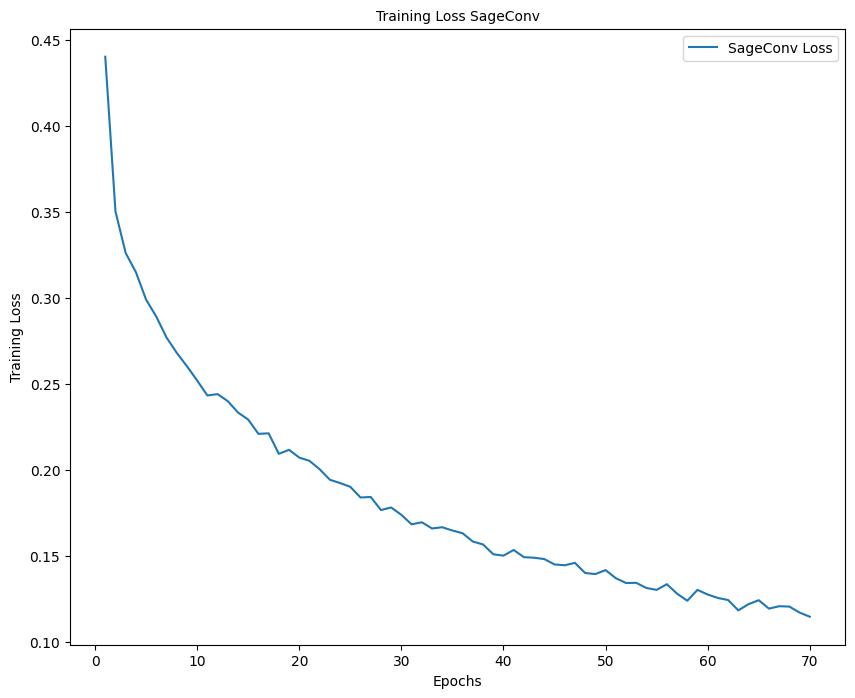

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 71)
plt.plot(epochs, sageconvloss, label='SageConv Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss SageConv')
plt.legend()
plt.show()


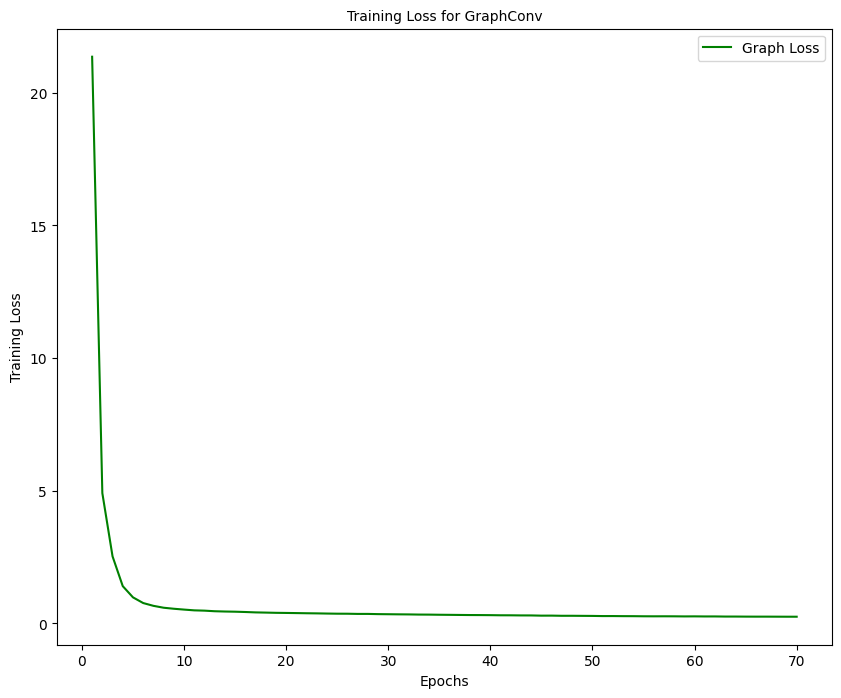

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 71)
plt.plot(epochs, graphconvloss, label='Graph Loss',color='green')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for GraphConv')
plt.legend()
plt.show()

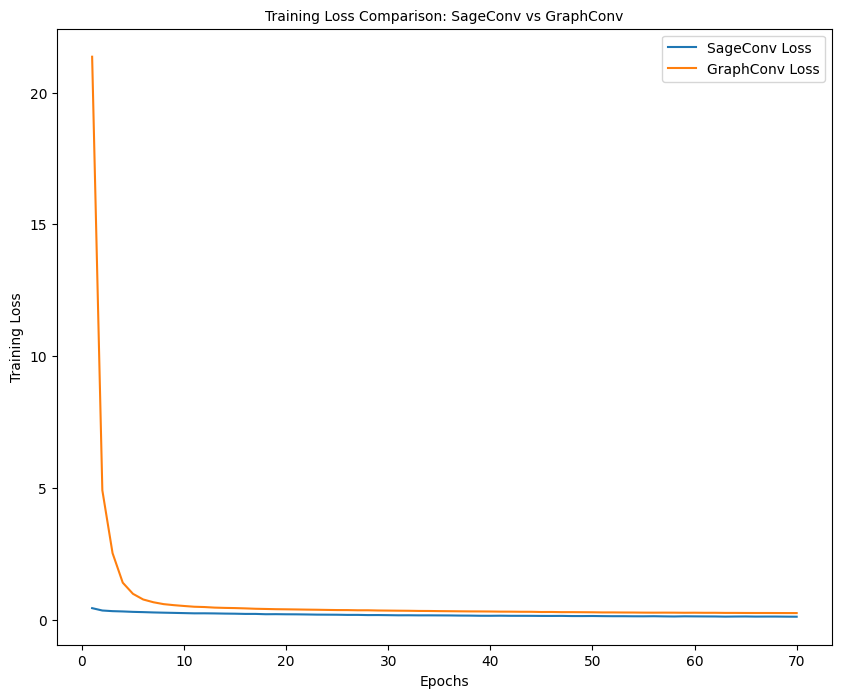

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 71)
plt.plot(epochs, sageconvloss, label='SageConv Loss')
plt.plot(epochs, graphconvloss, label='GraphConv Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison: SageConv vs GraphConv')
plt.legend()
plt.show()

In [ ]:
# sageconv and graphconv
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
#sage conv
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
sageconvauc=round(auc,4)

100%|██████████| 79/79 [00:02<00:00, 27.20it/s]


Validation AUC: 0.9144


In [ ]:
#graphconv
from sklearn.metrics import roc_auc_score
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model_conv(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
graphconvauc=round(auc,4)

100%|██████████| 79/79 [00:03<00:00, 20.86it/s]


Validation AUC: 0.8926


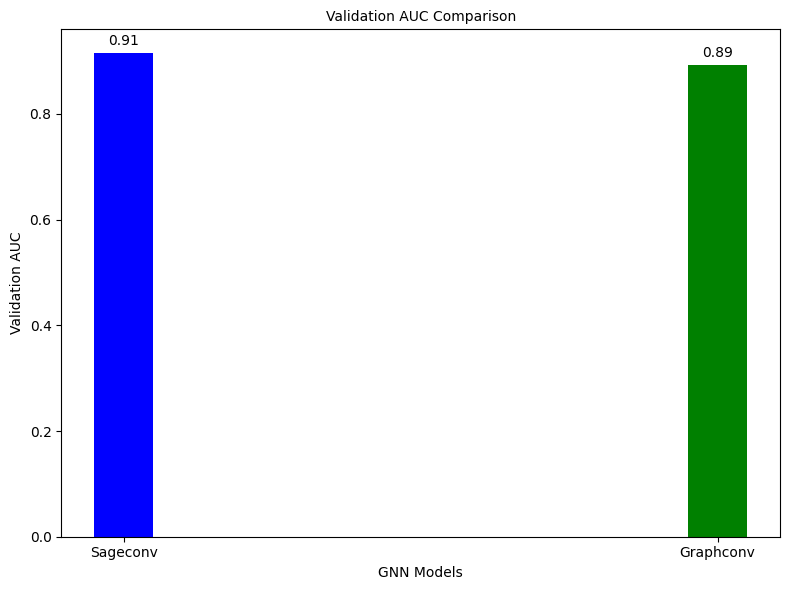

In [ ]:
import matplotlib.pyplot as plt

categories = ['Sageconv', 'Graphconv']
values = [sageconvauc, graphconvauc]
bar_width = 0.1
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=['blue', 'green'], width=bar_width)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(value, 2), ha='center', va='bottom')

plt.xlabel('GNN Models')
plt.ylabel('Validation AUC')
plt.title('Validation AUC Comparison')
plt.tight_layout()
plt.show()

In [ ]:
model = Model(hidden_channels=64)
model.load_state_dict(torch.load("/content/drive/MyDrive/ml-latest-small/model_40.pth"))
model.eval()


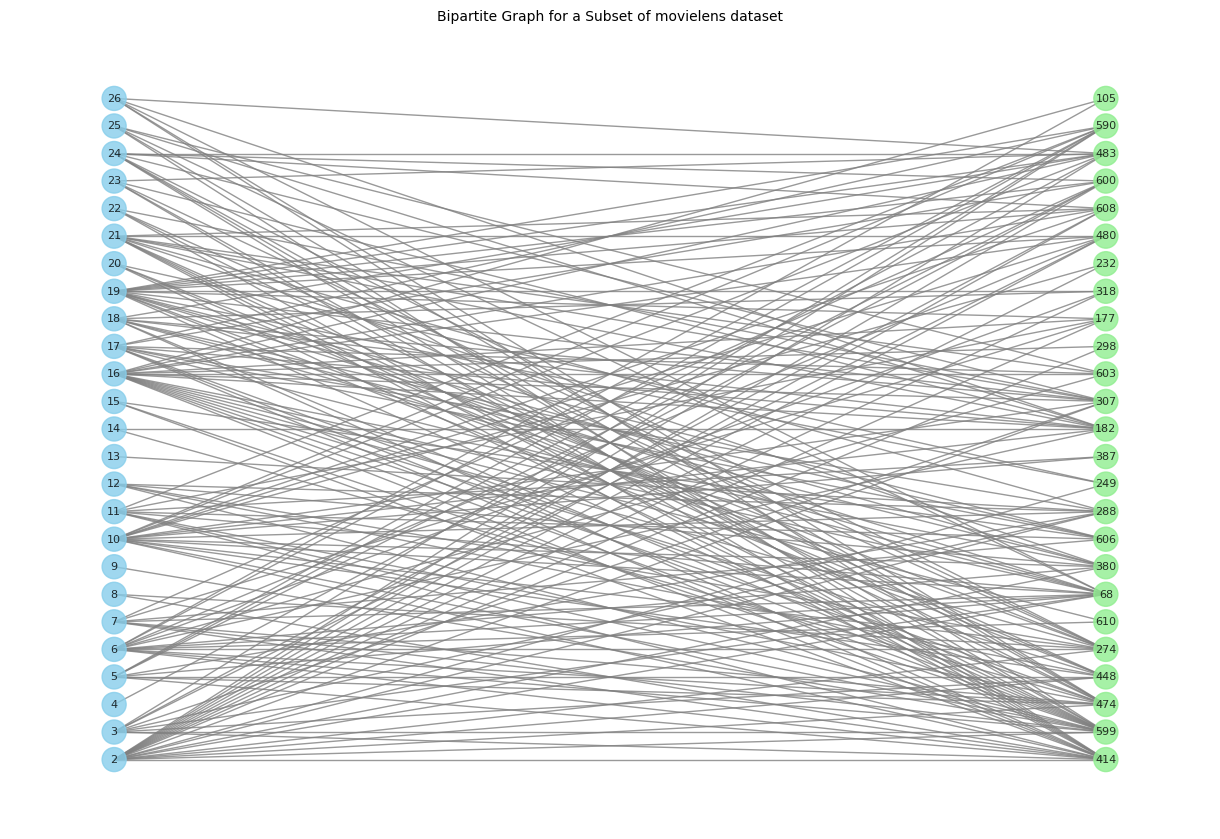

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

movies_subset = movies_df.iloc[1:,0].head(25).tolist()
movies_subset = [int(movie_id) for movie_id in movies_subset]
users_subset = ratings_df['userId'].head(25).tolist()
ratings_subset = ratings_df[(ratings_df['movieId'].isin(movies_subset)) & (ratings_df['userId'].isin(users_subset))]
users_with_most_ratings = ratings_df['userId'].value_counts().head(25).index.tolist()
ratings_subset = ratings_df[(ratings_df['movieId'].isin(movies_subset)) & (ratings_df['userId'].isin(users_with_most_ratings))]

B = nx.Graph()

B.add_nodes_from(movies_subset, bipartite=0)
B.add_nodes_from(users_with_most_ratings, bipartite=1)

for _, row in ratings_subset.iterrows():
    B.add_edge(row['userId'], row['movieId'])

node_colors = ['skyblue' if n in movies_subset else 'lightgreen' for n in B.nodes]

plt.figure(figsize=(12, 8))
pos = nx.bipartite_layout(B, nodes=movies_subset)
nx.draw(B, pos, node_size=300, with_labels=True, font_size=8, node_color=node_colors, alpha=0.8, font_color='black', edge_color='gray')
plt.title("Bipartite Graph for a Subset of movielens dataset")
plt.show()

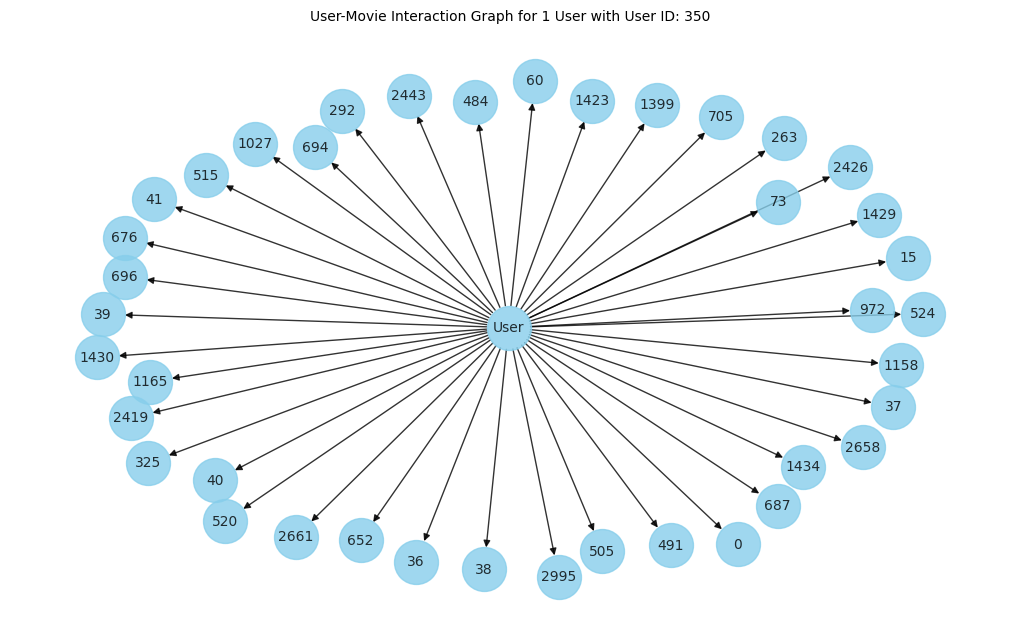

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt

num_users_to_sample = 1
sampled_user_ids = random.sample(list(unique_user_id['mappedID']), num_users_to_sample)
sampled_edge_indices = edge_index_user_to_movie[:, ratings_df['userId'] == sampled_user_ids[0]]
G = nx.DiGraph()
G.add_node("User", label="User")
for movie_id in sampled_edge_indices[1].unique():
    G.add_node(movie_id.item(), label="Movie")
for movie_id in sampled_edge_indices[1]:
    G.add_edge("User", movie_id.item())

user_id = sampled_user_ids[0]
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', alpha=0.8)
plt.title("User-Movie Interaction Graph for 1 User with User ID: " + str(user_id))  # Concatenate the string and user_id
plt.show()


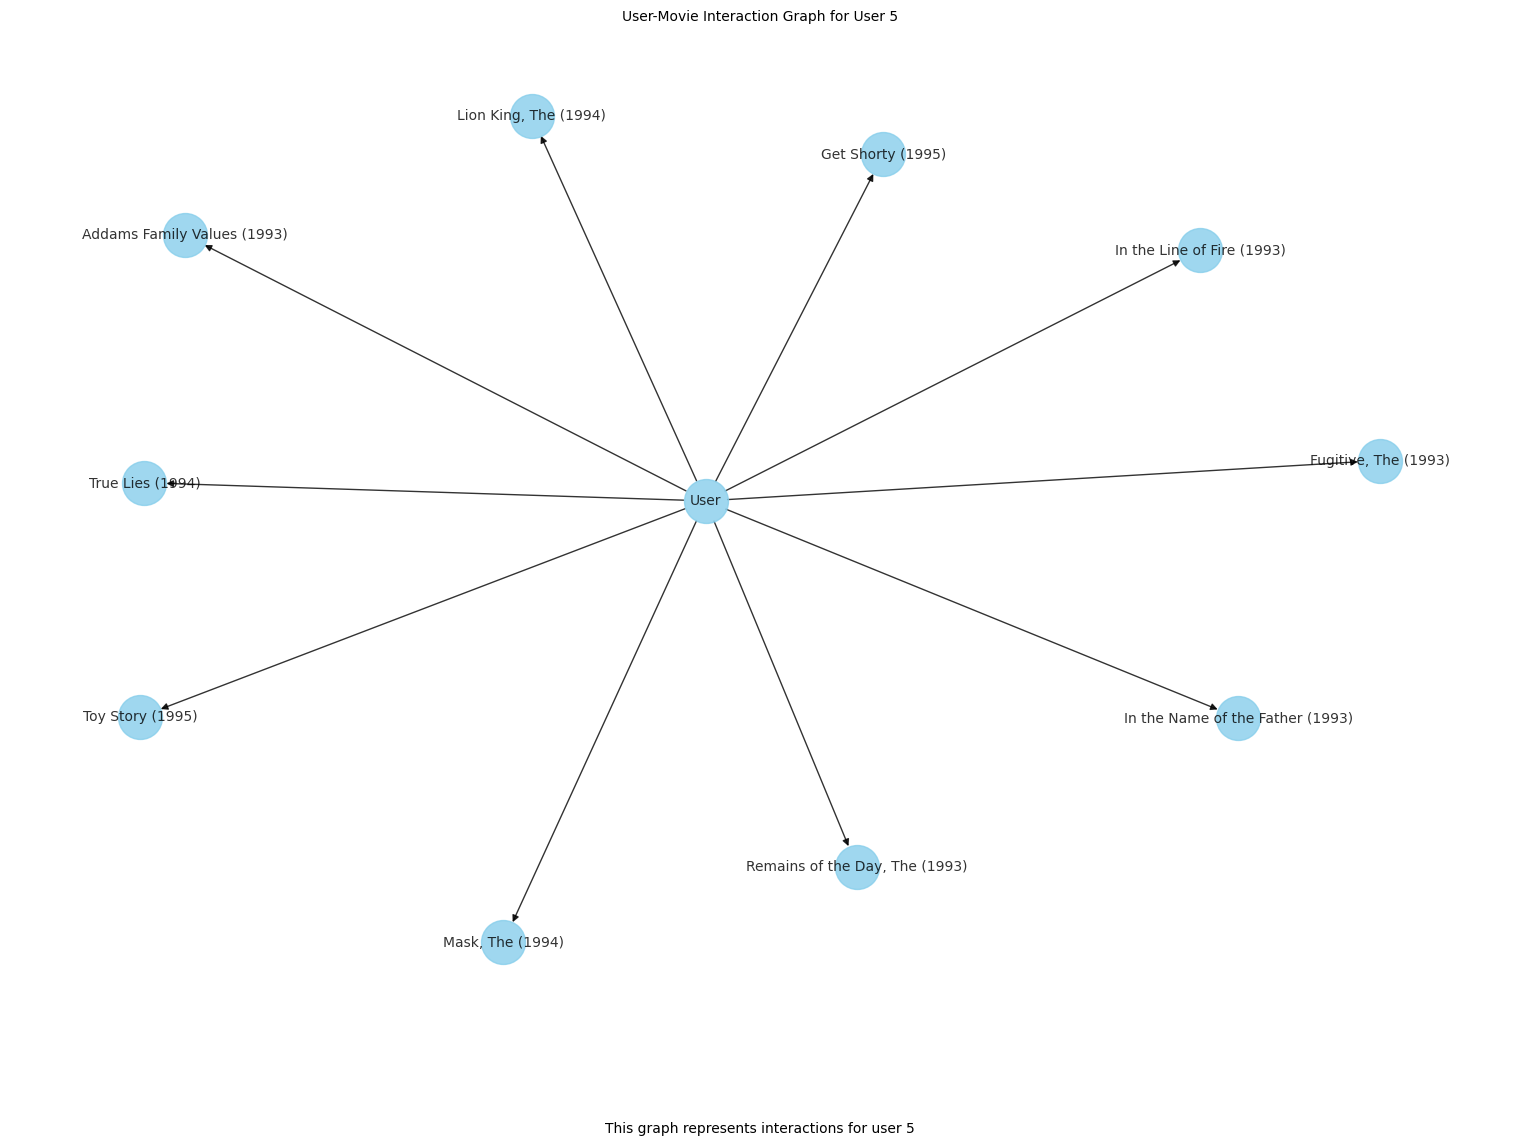

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

movies_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/movies.csv")
ratings_df = pd.read_csv("/content/drive/MyDrive/ml-latest-small/ratings.csv")
user_id = 5

user_ratings = ratings_df[ratings_df['userId'] == user_id]
top_rated_movies = user_ratings['movieId'].value_counts().head(10).index

G = nx.DiGraph()
G.add_node(user_id, label="User")

for movie_id in top_rated_movies:
    G.add_node(movie_id, label=movies_df.loc[movies_df['movieId'] == movie_id, 'title'].iloc[0])
    G.add_edge(user_id, movie_id)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, font_size=10, node_color='skyblue', alpha=0.8)
plt.title(f"User-Movie Interaction Graph for User {user_id}")
plt.text(0.5, -0.1, f"This graph represents interactions for user {user_id}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()


In [ ]:
import pandas as pd

movies_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
num_graphs = 1
print("Number of Graphs:", num_graphs)
num_movie_features = len(movies_df.columns) - 1
print("Number of Movie Features:", num_movie_features)
num_user_features = 0
print("Number of User Features:", num_user_features)
unique_classes = ratings_df['rating'].unique()
print("Classes (Rating Levels):", unique_classes)

Number of Graphs: 1
Number of Movie Features: 2
Number of User Features: 0
Classes (Rating Levels): [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]
